Assign the *Pets* dataset to a path object

In [1]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [2]:
path

Path('/home/petewin/.fastai/data/oxford-iiit-pet')

Change the base path of the `Path` object to a local relative one, in this case '.'

This will make our Path objects reference the hidden `.fastai/data` folder as if it were our local working directory

In [3]:
Path.BASE_PATH = path

In [4]:
Path.BASE_PATH

Path('.')

In [5]:
path.ls()

(#2) [Path('annotations'),Path('images')]

We'll be focusing on classification rather than localization, and so we'll ignore the annotations 

Most functions in fastai are going to return the `L` class, which is like an enhancement to the standard python `list` class

It can do a few extra things:

In [6]:
fname = (path/"images").ls()[:3]
fname

(#3) [Path('images/Birman_115.jpg'),Path('images/leonberger_142.jpg'),Path('images/Bombay_68.jpg')]

Above, it's showing that each item is a `Path` object and that there are `#3` items in this particular list

For longer lists it will add an ellipse `...` rather than try to spit out however many items

In [7]:
fname = (path/"images").ls()
fname

(#7393) [Path('images/Birman_115.jpg'),Path('images/leonberger_142.jpg'),Path('images/Bombay_68.jpg'),Path('images/japanese_chin_26.jpg'),Path('images/saint_bernard_149.jpg'),Path('images/Ragdoll_41.jpg'),Path('images/japanese_chin_32.jpg'),Path('images/Ragdoll_68.jpg'),Path('images/Persian_202.jpg'),Path('images/scottish_terrier_143.jpg')...]

We need to take note of the filenames here because some are one word, some are multiple words, all using an underscore `_` as a delimiter

In [8]:
fname = (path/"images").ls()[0]
fname

Path('images/Birman_115.jpg')

Regex to find any amount of characters until the last underscore is reached, then looks for a digit string and `.jpg`

In [9]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['Birman']

Fastai comes with a built-in `RegexLabeller` class, which we can use in creating out `pets` DataBlock

In [10]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

I'm always curious about some of the 'black box' aspects of programming in general. Not that it's really a black box, but I've made plenty of `DataBlock` objects at this point. So let's take a look under the hood

I'm going to make this a dataframe, just so it give me everything.<br>
`dir` is going to return all the attributes of my `pets` Datablock object now that it's created

In [11]:
df = pd.DataFrame(dir(pets))
df

,0
0,__class__
1,__delattr__
2,__dict__
3,__dir__
4,__doc__
5,__eq__
6,__format__
7,__ge__
8,__getattribute__
9,__gt__


In [12]:
pets.get_y

functools.partial(<function _using_attr at 0x7fc4499b41f0>, <fastai.data.transforms.RegexLabeller object at 0x7fc43d98e710>, 'name')

There we go, I was looking for the values at `get_y`, specifically what `name` was doing, and turns out it's just hanging out in there as a string - so likely for labeling(duh, but I wanted to see how)

`item_tmfs` and `batch_tmfs` in the above `DataBlock` are a data augmentation strategy called *presizing*, which is meant to perform image augmentation while minimizing data destruction and maintaining good performance

#### Presizing

Needs:
- Images to be the same dimensions so they can collate to tensors to head to the GPU
- Minimize the number of distinct augmentation computations we perform

Therefore:
- Where possible compose augmentation transforms into fewer tranforms and uniform image sizes


Complications:
- If we perform augmentations after resizing, we may introduce empty zones, degrade data, or both

Therefore:
- *Presizing*
    - Resize images to larger dimensions(scale up)
    - Compose all common augmentation operations(including rescale down) into a single one, and perform only at the end of processing

<img alt="Presizing on the training set" width="600" caption="Presizing on the training set" id="presizing" src="../images/att_00060.png">

Above:
1. Crop full width or height:
    - This is an `item_tfms` so it's done each image before it's copied to GPU; makes sure all images are the same size
        - For training - Random Area
        - For validation - Always Center Crop at Object Origin

2. Random crop and augment:
    - This is a `batch_tfms`, so it's applied to a batch all at once on the GPU; so it's fast
        - For training - Random crop and other augmentations are done first
        - For validation - Only resize to the final size needed for the model is done here



In [13]:
# default pandas dataframe maxes
pd_row_default = pd.options.display.max_rows
pd_column_default = pd.options.display.max_columns

In [14]:
# # Original
# #hide_input
# #id interpolations
# #caption A comparison of fastai's data augmentation strategy (left) and the traditional approach (right).
# dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
#                    get_y=parent_label,
#                    item_tfms=Resize(460))
# # Place an image in the 'images/grizzly.jpg' subfolder where this notebook is located before running this
# dls1 = dblock1.dataloaders([(Path.cwd()/'images'/'grizzly.jpg')]*100, bs=8)
# dls1.train.get_idxs = lambda: Inf.ones
# x,y = dls1.valid.one_batch()
# _,axs = subplots(1, 2)

# x1 = TensorImage(x.clone())
# x1 = x1.affine_coord(sz=224)
# x1 = x1.rotate(draw=30, p=1.)
# x1 = x1.zoom(draw=1.2, p=1.)
# x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

# tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
#                        Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
# x = Pipeline(tfms)(x)
# #x.affine_coord(coord_tfm=coord_tfm, sz=size, mode=mode, pad_mode=pad_mode)
# TensorImage(x[0]).show(ctx=axs[0])
# TensorImage(x1[0]).show(ctx=axs[1]);

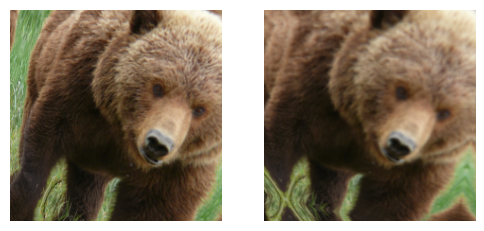

In [15]:
# Initialize a DataBlock with ImageBlock and CategoryBlock as blocks, using parent_label as get_y method, and resizing the image to 460
dlblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                    get_y=parent_label,
                    item_tfms=Resize(460))

# Create a path object 'Up_directory' with '..' as the path
Up_directory = Path('..')

# Create dataloaders 'dls1' from the DataBlock 'dlblock1' with 100 instances of grizzly.jpg and batch size of 8
dls1 = dlblock1.dataloaders([(Up_directory/'images'/'grizzly.jpg')]*100, bs=8)

# Set get_idxs of train dataloader to return Inf.ones
dls1.train.get_idxs = lambda: Inf.ones

# Get one batch of validation data from dls1
x,y = dls1.valid.one_batch()

# Plot images using subplots
_,axs = subplots(1,2)

# Initialize x1 with x and convert it to TensorImage
x1 = TensorImage(x.clone())

# Apply affine_coord transformation to x1 with size of 224
x1 = x1.affine_coord(sz=224)

# Apply rotate transformation to x1 with draw angle of 30 and probability of 1
x1 = x1.rotate(draw=30, p=1.)

# Apply zoom transformation to x1 with draw factor of 1.2 and probability of 1
x1 = x1.zoom(draw=1.2, p=1.)

# Apply warp transformation to x1 with draw factors for x and y of -0.2 and 0.2 respectively and probability of 1
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

# Set up augmentations using Rotate, Zoom, and Warp
tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])

# Apply the augmentations to x using Pipeline
x = Pipeline(tfms)(x)

# Show the first element of x after augmentations on first plot
TensorImage(x[0]).show(ctx=axs[0])

# Show the first element of x1 after augmentations on second plot
TensorImage(x1[0]).show(ctx=axs[1]);


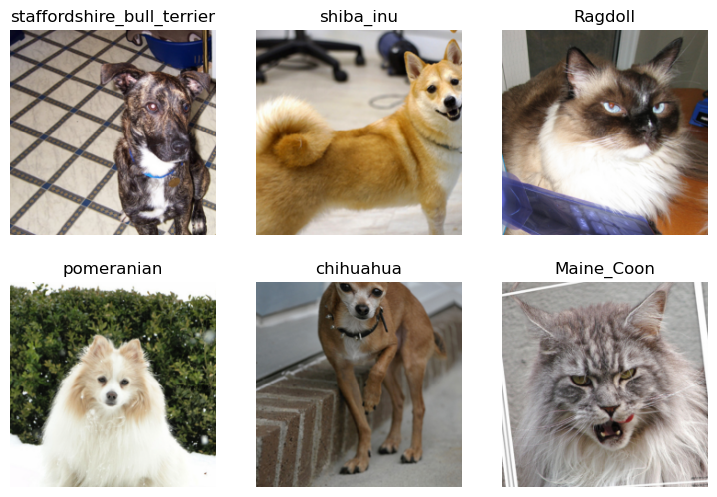

In [17]:
dls.show_batch(nrows=2, ncols=3)

To debug `DataBlock`s, we can use the `summary` method, which will attempt to make a batch from the source you give it, with lots of details

Below is a summary that forgets `Resize` transform for debugging:

In [18]:
pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
                            get_items=get_image_files,
                            splitter=RandomSplitter(seed=42),
                            get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))
pets1.summary(path/"images")                            

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/petewin/.fastai/data/oxford-iiit-pet/images/newfoundland_139.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x333
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /home/petewin/.fastai/data/oxford-iiit-pet/images/newfoundland_139.jpg
    applying partial gives
      newfoundland
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(27)

Final sample: (PILImage mode=RGB size=500x333, TensorCategory(27))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': Fals

RuntimeError: Error when trying to collate the data into batches with fa_collate, at least two tensors in the batch are not the same size.

Mismatch found on axis 0 of the batch and is of type `TensorImage`:
	Item at index 0 has shape: torch.Size([3, 333, 500])
	Item at index 1 has shape: torch.Size([3, 336, 500])

Please include a transform in `after_item` that ensures all data of type TensorImage is the same size

#### Train a Baseline

Most wait too long to train a baseline - do it early

In [19]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(2)

/home/petewin/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/petewin/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.645158,0.400673,0.119756,00:17


epoch,train_loss,valid_loss,error_rate,time
0,0.540254,0.288647,0.096752,00:19
1,0.376608,0.236426,0.076455,00:18
